### Задача кредитного скоринга

В рамках услуги ОП (оплати позже) клиенты могут взять в долг у компании, когда им необходимо оплатить пакет, а возможности пополнить счет нет. Услуга выдается на 7 дней, после чего необходимо вернуть денежные средства на счет. В тестовом датасете представлены данные, описывающие поведение клиентов после взятия ОП (вернул/не вернул). Необходимо построить скоринговую модель, которая на основании признаков клиента, прогнозирует, выдавать ли ему кредит или нет.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_pickle('data.pickle')

In [ ]:
data.head()

,app_id,claim_fd,count_days_between_packets,count_periods_between_packets,median_days_between_packets,mean_days_between_packets,variance_days_between_packets,months_in_YOTA,is_mnp,count_account_id,...,calls_out_cnt_uniq_opps,calls_in_minutes,calls_out_minutes,calls_in_minutes_mean,calls_out_minutes_mean,calls_in_minutes_median,calls_out_minutes_median,calls_in_minutes_variance,calls_out_minutes_variance,is_bad
0,1,2020-11-04 18:59:13,0.0,0,0.0,0.0,0.0,79,1,2,...,13.0,51.0,44.0,1.21,2.10,1.0,2.0,3.977352,1.890476,0
1,1,2021-02-03 19:02:05,0.0,0,0.0,0.0,0.0,82,1,2,...,18.0,97.0,48.0,1.39,1.55,1.0,1.0,3.370807,1.189247,0
2,9274,2020-10-08 14:01:00,0.0,0,0.0,0.0,0.0,78,0,1,...,23.0,73.0,178.0,1.33,3.36,1.0,1.0,1.150168,26.311321,0
3,274947,2020-10-11 23:45:28,0.0,0,0.0,0.0,0.0,74,0,2,...,67.0,339.0,292.0,1.37,1.72,1.0,1.0,0.986271,2.357675,0
4,274947,2020-12-11 00:05:42,0.0,0,0.0,0.0,0.0,76,0,2,...,58.0,306.0,233.0,1.67,2.06,1.0,2.0,2.913889,2.969343,0


### Оценка сбалансированность классов bad/good 

In [ ]:
data['is_bad'].value_counts()

0    983587
1     57473
Name: is_bad, dtype: int64

Дисбаланс в пользу людей кто все же вернул деньги, это естествено но все же надо проверить не вызван ли дисбаланс дубликатами.

In [ ]:
data.drop_duplicates().shape == data.shape

True

In [ ]:
#проверим наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041060 entries, 0 to 1041059
Data columns (total 75 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   app_id                         1041060 non-null  int64  
 1   claim_fd                       1041060 non-null  object 
 2   count_days_between_packets     1041060 non-null  float64
 3   count_periods_between_packets  1041060 non-null  int64  
 4   median_days_between_packets    1041060 non-null  float64
 5   mean_days_between_packets      1041060 non-null  float64
 6   variance_days_between_packets  1041060 non-null  float64
 7   months_in_YOTA                 1041060 non-null  int64  
 8   is_mnp                         1041060 non-null  int64  
 9   count_account_id               1041060 non-null  int64  
 10  have_pd                        1041060 non-null  int64  
 11  is_Russia                      1041060 non-null  int64  
 12  is_rus_pasport

In [ ]:
data['is_bad'].value_counts()[1] / data['is_bad'].value_counts()[0]

0.05843204515716454

Дисбаланс в данной ситуации является еще одним параметром данных и не нуждается в исправлении, надо будет лишь выбрать правильную метрику и модель. 

Буду использовать градиентный бустинг где в качестве loss функции используется LogLoss для которого балансировка классов не только избыточна но и неполезна (в случае если дисбаланс это следствие естественных причин)
https://dyakonov.org/2021/05/27/imbalance/

А в качестве метрик используем Roc auc, f1, recall, precision, CM

### Распределения признаков
3) чтоб правильно воспринимать разницу в распределениях нужна балансировка, сбалансируем времено данные.

Использую алгоритм RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

X = data.drop(columns=['is_bad'])
y = data['is_bad']
ros = RandomOverSampler(random_state=0)
data_balanced, y_resampled = ros.fit_resample(X, y)

In [ ]:
data_balanced['is_bad'] = y_resampled

In [ ]:
y_resampled.value_counts()

0    983587
1    983587
Name: is_bad, dtype: int64

In [ ]:
data_bad = data_balanced.loc[data_balanced['is_bad']==1].\
                                    drop(columns='is_bad')
data_good = data_balanced.loc[data_balanced['is_bad']==0].\
                                    drop(columns='is_bad')

Просмотрел все столбцы и вывел те где явно видна разница в разпределенниях по группам

(array([5.09581e+05, 1.66450e+04, 9.62150e+04, 1.38026e+05, 1.07863e+05,
        8.12710e+04, 2.36750e+04, 6.63800e+03, 1.83500e+03, 9.35000e+02,
        7.14000e+02, 6.60000e+01, 1.70000e+01, 3.20000e+01, 7.40000e+01]),
 array([   0.        ,   93.66666667,  187.33333333,  281.        ,
         374.66666667,  468.33333333,  562.        ,  655.66666667,
         749.33333333,  843.        ,  936.66666667, 1030.33333333,
        1124.        , 1217.66666667, 1311.33333333, 1405.        ]),
 <BarContainer object of 15 artists>)

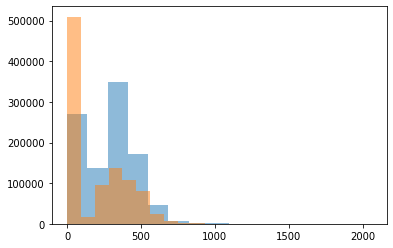

In [ ]:
column='price_packet_0'
plt.hist(data_good[column], alpha=0.5, bins=15)
plt.hist(data_bad[column], alpha=0.5, bins=15)

большенство тех кто не отдают долг выбирают самые дешевые пакеты

(array([1.03200e+03, 1.81608e+05, 3.71591e+05, 3.01444e+05, 8.82820e+04,
        3.37540e+04, 5.29900e+03, 5.16000e+02, 2.40000e+01, 3.70000e+01]),
 array([  0. ,  11.3,  22.6,  33.9,  45.2,  56.5,  67.8,  79.1,  90.4,
        101.7, 113. ]),
 <BarContainer object of 10 artists>)

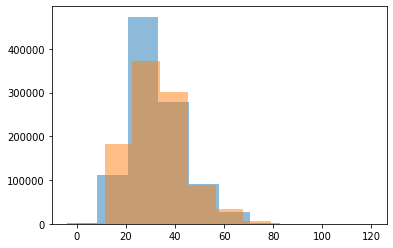

In [ ]:
column='age_come_YOTA'
plt.hist(data_good[column], alpha=0.5)
plt.hist(data_bad[column], alpha=0.5)

можно сказать что пользователи не возвративщие долг немного моложе

(array([284242., 203826., 128713.,  83954.,  63927.,  49192.,  94744.,
         48116.,  23303.,   3570.]),
 array([ 2. ,  9.5, 17. , 24.5, 32. , 39.5, 47. , 54.5, 62. , 69.5, 77. ]),
 <BarContainer object of 10 artists>)

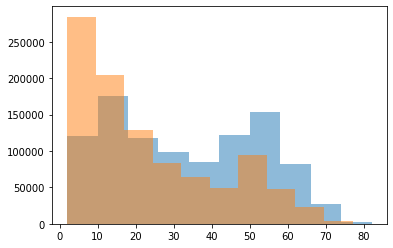

In [ ]:
column='months_in_YOTA'
plt.hist(data_good[column], alpha=0.5)
plt.hist(data_bad[column], alpha=0.5)

Разница понятна, люди берут ОП не оплачивают и уходят по этому у них маленький период пользования йота у неоплативших ОП

(array([2.64402e+05, 2.07882e+05, 1.80513e+05, 1.35783e+05, 9.91230e+04,
        5.75250e+04, 2.66590e+04, 9.34500e+03, 2.17600e+03, 1.79000e+02]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

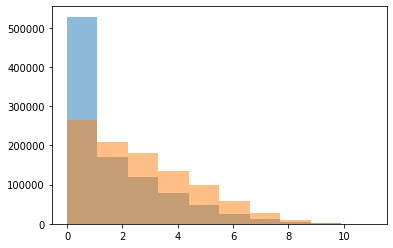

In [ ]:
column='count_periods_between_packets'
plt.hist(data_good[column], alpha=0.5)
plt.hist(data_bad[column], alpha=0.5)

Разделил список параметров на качественные и количественные

In [ ]:
continous_cols = ['count_days_between_packets',
       'count_periods_between_packets', 'median_days_between_packets',
       'mean_days_between_packets', 'variance_days_between_packets',
       'months_in_YOTA', 'count_account_id', 'age', 'age_come_YOTA', 'sum_refill_0',
       'count_refill_0', 'sum_refill_1', 'count_refill_1', 'sum_refill_part_1',
       'count_refill_part_1', 'sum_refill_2', 'count_refill_2',
       'sum_refill_part_2', 'count_refill_part_2', 'sum_payments_0',
       'count_payments_0', 'sum_payments_1', 'count_payments_1',
       'sum_payments_part_1', 'count_payments_part_1', 'sum_payments_2',
       'count_payments_2', 'sum_payments_part_2', 'count_payments_part_2',
       'price_options_0', 'count_options_0', 'price_options_1',
       'count_options_1', 'price_options_part_1', 'count_options_part_1',
       'price_options_2', 'count_options_2', 'price_options_part_2',
       'count_options_part_2', 'price_packet_0', 'price_packet_1',
       'price_packet_part_1', 'price_packet_2', 'price_packet_part_2',
       'count_beauty_number', 'count_numbers', 'count_verification',
       'count_payment_resourses_90d', 'count_good', 'count_bad',
       'calls_minutes_part_YOTA', 'count_smartphone', 'count_tablet',
       'count_modem', 'count_mikrocredit_sms', 'calls_in_cnt_calls',
       'calls_out_cnt_calls', 'calls_in_cnt_uniq_opps',
       'calls_out_cnt_uniq_opps', 'calls_in_minutes', 'calls_out_minutes',
       'calls_in_minutes_mean', 'calls_out_minutes_mean',
       'calls_in_minutes_median', 'calls_out_minutes_median',
       'calls_in_minutes_variance', 'calls_out_minutes_variance', 'is_bad'] 

In [ ]:
class_cols = ['is_mnp', 'have_pd', 'is_Russia', 'is_rus_pasport', 'cdi_gender', 'is_bad']
X_cols = list(set(class_cols + continous_cols) - set(['is_bad']))

проведем кореляционный анализ

In [ ]:
corr = data[continous_cols].corr()

In [ ]:
corr

,count_days_between_packets,count_periods_between_packets,median_days_between_packets,mean_days_between_packets,variance_days_between_packets,months_in_YOTA,count_account_id,age,age_come_YOTA,sum_refill_0,...,calls_out_cnt_uniq_opps,calls_in_minutes,calls_out_minutes,calls_in_minutes_mean,calls_out_minutes_mean,calls_in_minutes_median,calls_out_minutes_median,calls_in_minutes_variance,calls_out_minutes_variance,is_bad
count_days_between_packets,1.000000,0.548382,0.654031,0.796264,0.597547,-0.079603,-0.029077,0.018450,0.030802,-0.057621,...,-0.103108,-0.082262,-0.095791,-0.035372,-0.054597,-0.005192,-0.019783,-0.008967,-0.021014,0.167995
count_periods_between_packets,0.548382,1.000000,0.116299,0.203827,0.104131,-0.058088,-0.013857,0.019412,0.028635,-0.081798,...,-0.127174,-0.086957,-0.107871,-0.033503,-0.047999,-0.006523,-0.017255,-0.009422,-0.018583,0.135134
median_days_between_packets,0.654031,0.116299,1.000000,0.956108,0.390695,-0.067906,-0.010566,0.004156,0.014772,-0.011018,...,-0.046945,-0.042822,-0.045842,-0.017672,-0.029053,-0.002129,-0.012429,-0.002778,-0.010101,0.084890
mean_days_between_packets,0.796264,0.203827,0.956108,1.000000,0.506577,-0.075336,-0.015720,0.006954,0.018679,-0.022031,...,-0.062099,-0.054511,-0.060257,-0.023818,-0.037713,-0.003748,-0.015415,-0.004972,-0.013974,0.108915
variance_days_between_packets,0.597547,0.104131,0.390695,0.506577,1.000000,-0.030323,-0.018854,0.007169,0.011898,-0.019737,...,-0.036771,-0.032904,-0.036448,-0.016257,-0.023907,-0.003538,-0.010167,-0.004915,-0.009409,0.075813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
calls_in_minutes_median,-0.005192,-0.006523,-0.002129,-0.003748,-0.003538,-0.004301,-0.003865,0.023066,0.023418,-0.002611,...,-0.035458,0.126509,0.044730,0.610210,0.187156,1.000000,0.146717,0.279183,0.129991,-0.005400
calls_out_minutes_median,-0.019783,-0.017255,-0.012429,-0.015415,-0.010167,0.034095,-0.010819,0.011892,0.006575,0.012565,...,-0.036196,0.054711,0.131705,0.227650,0.694050,0.146717,1.000000,0.134294,0.312250,-0.014976
calls_in_minutes_variance,-0.008967,-0.009422,-0.002778,-0.004972,-0.004915,-0.005827,-0.003930,0.006761,0.007404,0.011697,...,-0.042239,0.274678,0.131955,0.733641,0.322792,0.279183,0.134294,1.000000,0.372753,-0.006975
calls_out_minutes_variance,-0.021014,-0.018583,-0.010101,-0.013974,-0.009409,0.018928,-0.003501,-0.002063,-0.004964,0.019436,...,-0.038329,0.160740,0.263796,0.353275,0.729094,0.129991,0.312250,0.372753,1.000000,-0.012975


In [ ]:
print('Коеффициенты Пирсона')
for column in corr.columns:
    a = corr[column].loc[(corr[column] > 0.8) & (corr[column] != 1)]
    if len(a) != 0:
        print(corr[column].name)
        print(dict(a))
        print() 

Коеффициенты Пирсона
median_days_between_packets
{'mean_days_between_packets': 0.9561078047150543}

mean_days_between_packets
{'median_days_between_packets': 0.9561078047150543}

age
{'age_come_YOTA': 0.98775150073048}

age_come_YOTA
{'age': 0.98775150073048}

sum_refill_part_1
{'sum_refill_part_2': 0.8871452063201147}

sum_refill_part_2
{'sum_refill_part_1': 0.8871452063201147}

sum_payments_part_1
{'sum_payments_part_2': 0.925541533830894}

sum_payments_part_2
{'sum_payments_part_1': 0.925541533830894}

price_options_0
{'count_options_0': 0.8468564081856897}

count_options_0
{'price_options_0': 0.8468564081856897}

price_options_1
{'count_options_1': 0.8410069680421537}

count_options_1
{'price_options_1': 0.8410069680421537}

price_options_2
{'count_options_2': 0.8381782414663353}

count_options_2
{'price_options_2': 0.8381782414663353}

calls_out_cnt_calls
{'calls_out_minutes': 0.8133968644386048}

calls_out_minutes
{'calls_out_cnt_calls': 0.8133968644386048}



Так как компьютер не справляется с обработкой такого количества информатиции, придется выбросить часть признаков, удалим те скорелированные так как их удаление не приведет к значительной потери информации

In [ ]:
corr_columns = ['mean_days_between_packets',  'age', 'sum_refill_part_2', 'sum_payments_part_2', 'count_options_0', 'count_options_1',
'count_options_2', 'calls_out_cnt_calls']

In [ ]:
spearman = np.abs(data[class_cols].corr('spearman'))

In [ ]:
print('Коеффициенты спирмана ')
for column in spearman.columns[:len(spearman.columns)]:
    a = spearman[column].loc[(spearman[column] > 0.5)  & (spearman[column] != 1)]
    if len(a) != 0:
        print(spearman[column].name)
        print(dict(a))
        print()

Коеффициенты спирмана 


корелируют между собой однообразные признаки, сгенерированные на основе тех же показателей. Коеффициент спирмана использовал чтоб оценить корреляцию качественных признаков, к слову она оказалась совсем незначительной

### проверка стат-тестами
c) для того чтоб оценить отличия по признакам, по каждому признаку выдвинем нулевую гипотезу о том что в данных нет отличий в зависимости от группы соответственно H1 будет обратной: "данные отличаются в зависимости от группы".

Уровень значимости возьмем alpha = 5%, и будем использовать z статистику так как  выборка довольно большая (ссылка)

Для удобства соберу все в цикл и буду выводить только название колонок где p-значение превышает установленный уровень значимости

In [ ]:
from scipy import stats

In [ ]:
def pooled_standard_error(a, b, unbias=False):
    '''Объединенная стандартная ошибка'''
    std1 = a.std(ddof=0) if unbias==False else a.std() 
    std2 = b.std(ddof=0) if unbias==False else b.std()
    x = std1 ** 2 / a.shape[0]
    y = std2 ** 2 / b.shape[0]
    return np.sqrt(x + y)

def z_stat(a, b, unbias=False):
    return (a.mean() - b.mean()) / pooled_standard_error(a, b, unbias)

def z_test(a, b): 
    z = stats.norm.cdf([ z_stat(a, b) ])[0]
    return z

def testing(column, alpha):
    '''Сравнение данных по группам'''
    groups = data.groupby('is_bad')[column]
    a = groups.get_group(0)
    b = groups.get_group(1) 
    if z_test(a, b) < alpha:
        print(column)
        print('a n:         ', a.count())
        print('b n:         ', b.count())
        print('z-статистика:', z_stat(a, b))
        print('p-значение:  ', z_test(a, b))
    else:
        return column

In [ ]:
h0_columns = []
for column in continous_cols:
    if testing(column, alpha=0.05):
        h0_columns.append(testing(column, alpha=0.05))

count_days_between_packets
a n:          983587
b n:          57473
z-статистика: -120.30176495176184
p-значение:   0.0
count_periods_between_packets
a n:          983587
b n:          57473
z-статистика: -131.7004174705109
p-значение:   0.0
median_days_between_packets
a n:          983587
b n:          57473
z-статистика: -66.76823393206227
p-значение:   0.0
mean_days_between_packets
a n:          983587
b n:          57473
z-статистика: -85.30774748592339
p-значение:   0.0
variance_days_between_packets
a n:          983587
b n:          57473
z-статистика: -43.510611376274504
p-значение:   0.0
age_come_YOTA
a n:          983587
b n:          57473
z-статистика: -14.135957829703163
p-значение:   1.140051872358163e-45
sum_payments_part_1
a n:          983587
b n:          57473
z-статистика: -30.4480494729268
p-значение:   6.356414060761042e-204
count_payments_part_1
a n:          983587
b n:          57473
z-статистика: -54.00321669641308
p-значение:   0.0
sum_payments_2
a n:         

In [ ]:
h0_columns

['months_in_YOTA',
 'count_account_id',
 'age',
 'sum_refill_0',
 'count_refill_0',
 'sum_refill_1',
 'count_refill_1',
 'sum_refill_part_1',
 'count_refill_part_1',
 'sum_refill_2',
 'count_refill_2',
 'sum_refill_part_2',
 'count_refill_part_2',
 'sum_payments_0',
 'count_payments_0',
 'sum_payments_1',
 'count_payments_1',
 'count_payments_2',
 'price_options_0',
 'count_options_0',
 'price_options_1',
 'count_options_1',
 'price_options_part_1',
 'count_options_part_1',
 'price_options_2',
 'count_options_2',
 'price_options_part_2',
 'count_options_part_2',
 'price_packet_0',
 'price_packet_1',
 'price_packet_part_1',
 'price_packet_part_2',
 'count_beauty_number',
 'count_numbers',
 'count_verification',
 'count_good',
 'calls_minutes_part_YOTA',
 'count_tablet',
 'count_modem',
 'count_mikrocredit_sms',
 'calls_in_cnt_calls',
 'calls_out_cnt_calls',
 'calls_in_cnt_uniq_opps',
 'calls_out_cnt_uniq_opps',
 'calls_in_minutes',
 'calls_out_minutes',
 'calls_in_minutes_mean',
 'calls

для выведенных столбцов мы отвергаем нулевую гипотезу о том что в данных нет значимых отличий, для остальных (собранных в лист h0_columns) принимаем

получили статистически важные различия как раз в тех столбцах (и в скореллированных с ними) в которых и на графиках были заметны отличия

Так как существуют признаки сильно скореллированные между собой (по сути приносящие одинаковую информацию) и по скольку мощность моего домашнего компьютера не позволяет мне работать эффективно с датасетом (даже с алгоритмами класстеризации optics, dbscan не справляется компьютер) данного размера, я понижу размерность.

До того как сделать вывод о том какие переменые стоит убрать, построю еще логистическую регрессию с L1 регуляризацией чтоб посмотреть какие фичи она занулит, но перед этим стоит шкалировать признаки для того чтоб можно было в следствии интерпертировать коеффициенты

In [ ]:
from sklearn.preprocessing import StandardScaler

X = data[X_cols].values

y = data['is_bad'].values

X = StandardScaler().fit_transform(X)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(C=1, penalty='l1', solver='liblinear')\
                                                    .fit(X, y)

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
print('roc_auc_score: ', roc_auc_score(data['is_bad'], log_clf.predict(data[X_cols])))
print('recall_score: ', recall_score(data['is_bad'], log_clf.predict(data[X_cols])))
print('precision_score: ', precision_score(data['is_bad'], log_clf.predict(data[X_cols])))

roc_auc_score:  0.5209523257618857
recall_score:  0.7986358811963878
precision_score:  0.058085751780220726


Так как у нас специфика задачи такая чтоб и не отдать слишком много кредитов которые не вернут, но и не отказывать добросовестным пользователям чтоб не испортить их user expirience мы должны максимизировать и precision и recall держа баланс между ними. 

Но вообще надо бы посчитать сколько нам стоят ошибка первого рода и сколько вторая чтоб лучше определить цель (в численном виде)

Мне кажется что критичнее ситуация когда отдали кредит и человек не вернул поэтому выгоднее максимизировать TP

In [ ]:
pd.Series(log_clf.predict(X)).value_counts()

0    1039329
1       1731
dtype: int64

Большое количество ошибок FN, посмотрим какие фичи модель занулила

In [ ]:
(np.abs(log_clf.coef_).mean(), np.abs(log_clf.coef_).std())

(0.17618958879726698, 0.4719796750977146)

In [ ]:
coefs = np.abs(log_clf.coef_)

In [ ]:
counter = 0
for i in range(log_clf.coef_.shape[1]):
    if np.abs(log_clf.coef_)[0, i] < np.abs(log_clf.coef_).mean()/3:
        print(X_cols[i])
        counter += 1
print(counter)

calls_in_minutes
count_payments_1
sum_refill_2
calls_out_cnt_calls
count_payments_part_1
calls_out_minutes_median
sum_payments_part_1
count_mikrocredit_sms
price_options_part_2
price_options_2
sum_refill_part_2
count_options_1
calls_in_minutes_median
price_options_part_1
count_modem
count_refill_1
variance_days_between_packets
price_packet_2
is_Russia
count_options_2
count_payments_2
price_options_1
calls_in_cnt_uniq_opps
sum_refill_0
sum_refill_1
count_options_part_2
cdi_gender
count_options_part_1
calls_out_minutes_variance
count_payments_part_2
sum_refill_part_1
count_verification
count_tablet
count_refill_part_1
count_refill_0
calls_minutes_part_YOTA
sum_payments_part_2
count_payments_0
count_refill_part_2
count_beauty_number
is_rus_pasport
calls_in_minutes_variance
count_refill_2
43


Пока не буду удалять признаки на основе решения log_clf, так как она занулила большинство фичей и делает предсказание на основе топ 10-15

уберем параметры которые попадут в обьеденение столбцов сильно скорелированных (оставим по одному из пары) и тех в которых не обнаруженно различие по группам статистическими тестами, для того чтоб сильнее обезопасится от выбрасывания важных столбцов.

Запишу их в переменную

In [ ]:
X_cols_small = list(set(X_cols) - set((corr_columns + h0_columns)))

### Снижение размерности
4) Алгоритмы понижения размерности можно разделить на 2 основные группы: они пытаются сохранить либо глобальную структуру данных, либо локальные расстояния между точками. К первым относятся такие алгоритмы как Метод главных компонент (PCA), а ко вторым — t-SNE или более эфективный UMAP. https://habr.com/ru/company/newprolab/blog/350584/

Я буду использовать алгоритм PCA так как остальные алгоритмы слишком долго считались.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, data[['is_bad']]], axis = 1)

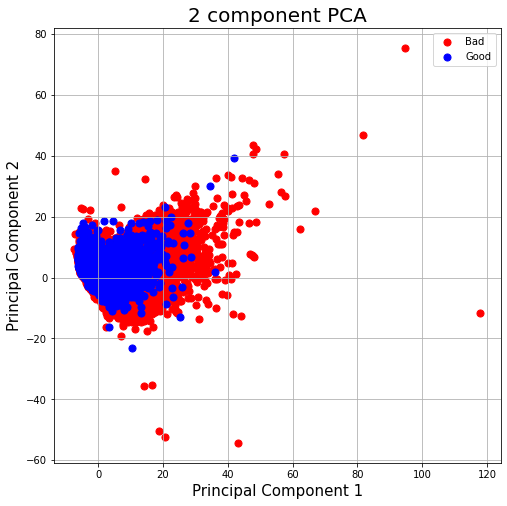

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Bad', 'Good']
colors = ['red', 'blue']

ax.scatter(finalDf.loc[finalDf['is_bad'] == 0, 'principal component 1']
           , finalDf.loc[finalDf['is_bad'] == 0, 'principal component 2']
           , c = colors[0]
           , s = 50)

ax.scatter(finalDf.loc[finalDf['is_bad'] == 1, 'principal component 1']
           , finalDf.loc[finalDf['is_bad'] == 1, 'principal component 2']
           , c = colors[1]
           , s = 50)

ax.legend(targets)
ax.grid()

двух признаков недостаточно для того чтоб хорошо разделить классы, но видно что сильные откланения от центров облак свидетельствует о принодлежности точки к классу Bad

b) предстоит выбрать алгоритм кластеризации, наше преемущество в том что мы знаем сколько кластеров мы хотим получить но негативная особенность это большой размер датасета, для этой задачи лучше подойдет Birch. 
https://scikit-learn.ru/clustering/#birch

DBscan, Birch и optics слишком долго обучаются на моем компьютере, ниже
попытка исправить ситуацию и обьяснение к ней.

В итоге я использую быстрый Kmeans

In [ ]:
from sklearn.cluster import OPTICS, DBSCAN, KMeans, Birch
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [ ]:
clust = KMeans(n_clusters=2)

In [ ]:
from sklearn.model_selection import train_test_split
#пробывал понизить размер датасета до (200k; 18)
X_20, X_80 = train_test_split(data[X_cols], test_size=.8, stratify=data['is_bad'])

In [ ]:
%%time
clust.fit(data[X_cols])

CPU times: user 45.1 s, sys: 2.28 s, total: 47.4 s
Wall time: 15.2 s


KMeans(n_clusters=2)

In [ ]:
roc_auc_score(data['is_bad'], clust.predict(data[X_cols]))

0.5088219334414756

хотел использовать dbscan/optics/birch, но к сожалению компьютер не тянет обучение даже на датасете с размером (200k; 18), по этому пришлось использовать kmeans, хоть он и не справляется обычно даже с рядом классичских задач

с) Ответим на вопрос сколько размерностей достаточно чтоб описать 90% исходной дисперсии, для этого используем алгоритм pca.

Сразу провизуализируем результат

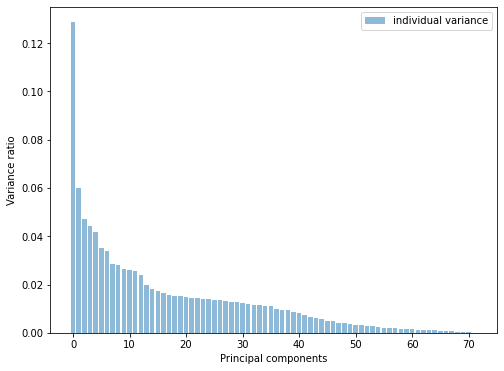

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X)
pca_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(72), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

по графику можем заметить несколько порогов, которые можем выбрать для решения сколько компонент выбрать, в районе 7 и 12

In [ ]:
i = 0
sum_ration = 0
while sum_ration < 0.9:
    sum_ration += pca_variance[i]
    i += 1
print('чтоб обяснить 90% исходной дисперсии достаточно ', i,' размерностей')

чтоб обяснить 90% исходной дисперсии достаточно  39  размерностей


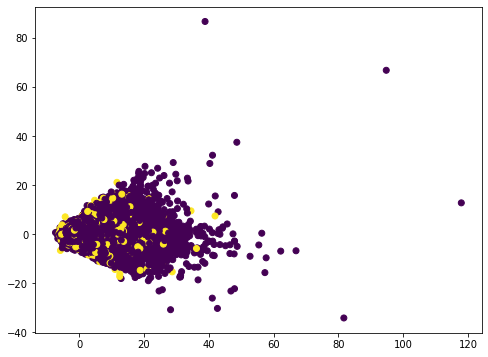

In [ ]:
# посмотрим как на графике выделяются облака по классам
pca2 = PCA(n_components=39)
pca2.fit(X)
x_3d = pca2.transform(X)

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,5], c=data['is_bad'])
plt.show()

### Построение моделей классификации

5) Начнем строить модели классификации, мы уже попробывали логистический классификатор возьмем его как бэйзлайн, дальше попробуем ансамбли: лес деревьев, и бустинги. 

Из бустингов соит попробывать тоже разные так как они отличаются реализацией например одно из отличий между xgboost и catboost это  то что catboost использует в качестве деревьев решающие таблицы (разновидность деревьев которая как раз были выведены для решения задачь с большим количеством нерелевантных признаков) которыйе к слову и очень эффективны так как в итоге получаем одну решающую таблицу (сумму всех остальных таблиц) что будет важно при большой нагрузке на систему.
https://habr.com/ru/company/ods/blog/645887/

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[X_cols],\
                                   data['is_bad'], test_size=.8, random_state=20, stratify=data['is_bad'])

In [ ]:
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

In [ ]:
%%time
forest_clf = RandomForestClassifier(max_depth=10).fit(X_train, y_train)

CPU times: user 19min 57s, sys: 3.75 s, total: 20min 1s
Wall time: 20min 23s


In [ ]:
%%time
cat_clf = CatBoostClassifier(silent=True, 
                             random_seed=42,).fit(X_train, y_train)

CPU times: user 1min 7s, sys: 673 ms, total: 1min 7s
Wall time: 20.2 s


In [ ]:
%%time
bst = xgb.XGBClassifier(objective='binary:logistic')
bst.fit(X_train, y_train)

CPU times: user 3min 24s, sys: 1.03 s, total: 3min 25s
Wall time: 57.1 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

результаты дерева

In [ ]:
confusion_matrix(y_test, forest_clf.predict(X_test))

array([[786555,    315],
       [ 45381,    597]])

In [ ]:
roc_auc_score(y_test, forest_clf.predict(X_test))

0.506292075288836

In [ ]:
print(classification_report(y_test, forest_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    786870
           1       0.65      0.01      0.03     45978

    accuracy                           0.95    832848
   macro avg       0.80      0.51      0.50    832848
weighted avg       0.93      0.95      0.92    832848



дерево в большинстве предсказывает доминантный класс. Чтоб использовать данный алгоритм нужна балансировка классов

результаты catboost

In [ ]:
confusion_matrix(y_test, cat_clf.predict(X_test))

array([[784685,   2185],
       [ 43839,   2139]])

In [ ]:
roc_auc_score(y_test, cat_clf.predict(X_test))

0.5218727125686597

In [ ]:
print(classification_report(y_test, cat_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    786870
           1       0.49      0.05      0.09     45978

    accuracy                           0.94    832848
   macro avg       0.72      0.52      0.53    832848
weighted avg       0.92      0.94      0.92    832848



Результат xgboost

In [ ]:
confusion_matrix(y_test, bst.predict(X_test))

array([[783334,   3536],
       [ 42693,   3285]])

In [ ]:
pd.Series(bst.predict(X_test)).value_counts()

0    826027
1      6821
dtype: int64

In [ ]:
roc_auc_score(y_test, bst.predict(X_test))

0.5334767300758781

In [ ]:
print(classification_report(y_test, bst.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    786870
           1       0.48      0.07      0.12     45978

    accuracy                           0.94    832848
   macro avg       0.71      0.53      0.55    832848
weighted avg       0.92      0.94      0.92    832848



Лучше результат показал xgboost (f1 precision)

Найдем топ 11 признаков среди коеффициентов логистической регрессии обученой ранее

In [ ]:
top_features_df = pd.DataFrame({'coefs': coefs[0], 'column_names': X_cols}).sort_values(by='coefs', ascending=False)

In [ ]:
top_features_df.column_names

51                    age
7           age_come_YOTA
22       count_account_id
36       count_smartphone
70             count_good
             ...         
26    count_refill_part_2
55        price_options_1
3       sum_refill_part_2
31           count_tablet
69      sum_refill_part_1
Name: column_names, Length: 72, dtype: object

уберем из топа по одному из пар силльно скореллированых колонок, в данном случае 'age'

In [ ]:
top_cols = top_features_df.loc[top_features_df['column_names'] != 'age', 'column_names'].iloc[:11]
top_cols

7                     age_come_YOTA
22                 count_account_id
36                 count_smartphone
70                       count_good
48       count_days_between_packets
17              price_packet_part_1
28                           is_mnp
53                   price_packet_0
66              price_packet_part_2
57    count_periods_between_packets
6           calls_out_cnt_uniq_opps
Name: column_names, dtype: object

Посмотрим еще на feature importance у catboost и xgboost

In [ ]:
cat_coefs = cat_clf.get_feature_importance()

In [ ]:
top_features_cat = pd.DataFrame({'coefs': cat_coefs, 'column_names': X_train.columns}).sort_values(by='coefs', ascending=False)

в топе присутствую скореллированные между собой признаки, удалим по одномк из пар

In [ ]:
top_cols_cat = top_features_cat.loc[(top_features_cat['column_names'] != 'median_days_between_packets') & \
                                    (top_features_cat['column_names'] != 'variance_days_between_packets') & \
                                    (top_features_cat['column_names'] != 'count_payments_part_2') & \
                                    (top_features_cat['column_names'] != 'mean_days_between_packets') 
                                    , 'column_names'].iloc[:11]
top_cols_cat

22                 count_account_id
70                       count_good
61                   months_in_YOTA
48       count_days_between_packets
36                 count_smartphone
28                           is_mnp
57    count_periods_between_packets
20            count_payments_part_1
51                              age
4             calls_in_minutes_mean
69                sum_refill_part_1
Name: column_names, dtype: object

топ признаков в от части совпадает с тем что у логистичческой моделью, но не полностью

Посмотрим feature importance и у xgboost

In [ ]:
bst_coefs = bst.feature_importances_
top_features_xgb = pd.DataFrame({'coefs': bst_coefs, 'column_names': X_train.columns}).sort_values(by='coefs', ascending=False)

In [ ]:
top_cols_xgb = top_features_xgb.loc[(top_features_xgb['column_names'] != 'median_days_between_packets') &\
                                    (top_features_xgb['column_names'] != 'count_days_between_packets') &\
                                   (top_features_xgb['column_names'] != 'variance_days_between_packets')].iloc[:11]
top_cols_xgb

,coefs,column_names
65,0.072921,mean_days_between_packets
22,0.067068,count_account_id
17,0.058081,price_packet_part_1
61,0.038764,months_in_YOTA
70,0.037154,count_good
28,0.034162,is_mnp
36,0.028213,count_smartphone
58,0.028168,count_bad
53,0.017197,price_packet_0
57,0.016248,count_periods_between_packets


Обучимся на этих признаках

In [ ]:
top_cols = list(top_cols_xgb.column_names)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[top_cols],\
                                   data['is_bad'], test_size=.8, random_state=20, stratify=data['is_bad'])

In [ ]:
cat_clf = CatBoostClassifier(silent=True).fit(X_train, y_train)
bst = xgb.XGBClassifier(objective='binary:logistic')
bst.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
%%time
log_clf = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train, y_train)

CPU times: user 1.16 s, sys: 53.3 ms, total: 1.21 s
Wall time: 923 ms


In [ ]:
print('результаты для catboost \n',\
      confusion_matrix(y_test, cat_clf.predict(X_test)),\
      roc_auc_score(y_test, cat_clf.predict(X_test)))

результаты для catboost 
 [[784686   2184]
 [ 43833   2145]] 0.5219385965947929


In [ ]:
print('результаты для xgboost \n', \
      confusion_matrix(y_test, bst.predict(X_test)),\
      roc_auc_score(y_test, bst.predict(X_test)))

результаты для xgboost 
 [[784899   1971]
 [ 44036   1942]] 0.5198663654300459


In [ ]:
print('результаты для log_clf \n', \
      confusion_matrix(y_test, log_clf.predict(X_test)),\
      roc_auc_score(y_test, log_clf.predict(X_test)))

результаты для log_clf 
 [[786346    524]
 [ 45747    231]] 0.5021791062059476


В общем метрики стали не сильно хуже так что можем считать успешным решение предсказывать только на топ 11 признаках так как это эффективнее и понижаем возможное заучивание ложных зависимостей. Сделав обрезку параметров, мы потеряли небольшой обьем информации но при этом избегаем переобучение.

6) Для того чтоб прогнозировать количество is_bad в новом периоде будем решать задачу временных рядов. (авторегрессия)

Для этого сформируем датасет x = месяц, y = доля is_bad 

In [ ]:
data['X'] = data['claim_fd'].apply(lambda x: int(x[:4])*12  + int(x[5:7]))

In [ ]:
# нормализуем 
data['X'] -= data['X'].min()

In [ ]:
data['X'].value_counts()

4    232650
3    221016
2    208839
1    207527
5    124729
0     46299
Name: X, dtype: int64

по 6 точкам будет сложно хорошо предсказывать седьмую

построим фичу is_bad_rate

In [ ]:
data['is_bad_rate'] = np.ones(data.shape[0])

In [ ]:
for i in range(6):
    print(i)
    data.loc[data['X'] == i, 'is_bad_rate'] = data.loc[data['X'] == i, 'is_bad'].mean()

0
1
2
3
4
5


<AxesSubplot:xlabel='X', ylabel='is_bad_rate'>

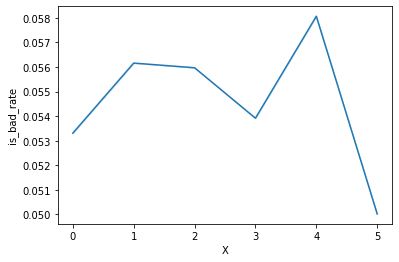

In [ ]:
sns.lineplot(x=data['X'], y=data['is_bad_rate'], )

В классическом варианте решения задачи времянного ряда, надо ряд привести к стационарному виду (убрать периодичность, тренд и стандартизировать y (E(x)=0, D(x)=1)) но тут я проведу только стандартизацию

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(data[['is_bad_rate']])
data[['is_bad_rate_scaled']] = scaler.transform(data[['is_bad_rate']])

<AxesSubplot:xlabel='X', ylabel='is_bad_rate_scaled'>

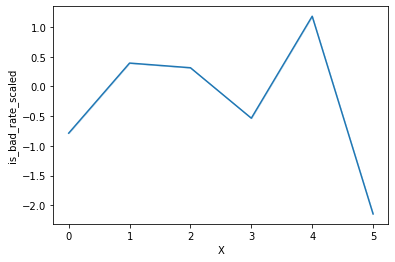

In [ ]:
sns.lineplot(x=data['X'], y=data['is_bad_rate_scaled'])

In [ ]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

In [ ]:
dta = data['is_bad_rate_scaled'].copy()
dta.index = data['X']

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


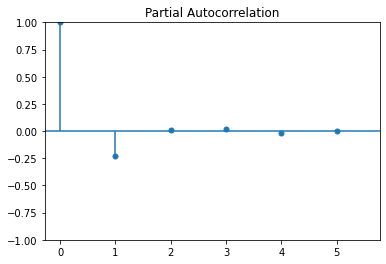

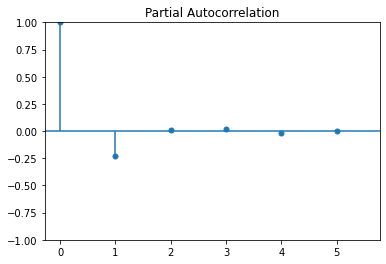

In [ ]:
sm.graphics.tsa.plot_pacf(dta, lags=5)

In [ ]:
df = data.sort_values(by='X')[['X', 'is_bad_rate_scaled']].drop_duplicates()

In [ ]:
df.index = df.X

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


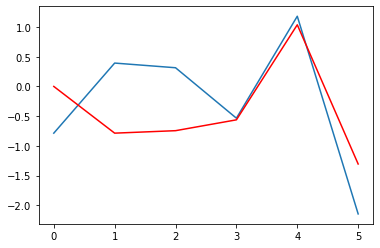

In [ ]:
model = ARIMA(df['is_bad_rate_scaled'], order=(2,1,2))
results = model.fit()
plt.plot(df['is_bad_rate_scaled'])
plt.plot(results.fittedvalues, color='red')

предскажем значение доли is_bad для следующего месяца

In [ ]:
scaler.inverse_transform(np.array(results.forecast()[6]).reshape(-1, 1))

array([[0.06122563]])

In [ ]:
predictet_ts = results.fittedvalues
predictet_ts[6] = scaler.inverse_transform(np.array(results.forecast()[6]).reshape(-1, 1))

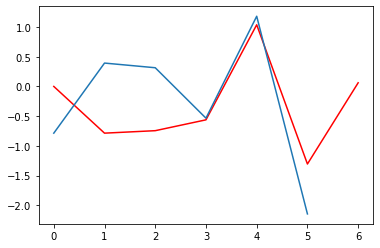

In [ ]:
plt.plot(predictet_ts, color='red')
plt.plot(df['is_bad_rate_scaled'])

In [ ]:
predictet_ts[6]

array([[0.06122563]])

5 точек это слишком мало для применения сложных статистических моеделй, по этому я не приобразовывал ряд и взял модель ARIMA.

Даже в условии маленького количества данных она справилась неплохо

### 7) 
- Нужно посчитать ошибка какого типа нам стоит дороже чтоб решить какую метрику все же стоит оптимизировать и если нет однозначности то разработать свою метрику учитывая теоретические расход/прибыль бизнеса 


- Нужно больше экспериментировать с случайным лесом сбалансировав перед этим данные, и перебрав разные критерии ограничения леса и его деревьев 


-  Попробывать обучать модели не на топ 11 признаков а на датасете уменьшенной (с помощью алгоритмов ML) размерности 


- Надо добавить качественный признак некой доверенности клиента, первый раз ли он берет кредит или он уже брал и возвращал. И параметр сколько кредитов он вернул. Можно назвать это кредитной историей


- По распределениямт было видно что чаще не возвращают кредиты те кто брал их в первый раз.


- Можно больше времени уделить перебору гиперпараметров, для лучшей настройки модели. Особенно с порогом вероятности при которой обьект относится к классу (так сможем регулировать баланс FP / FN)


- Нужно использовать машину по мощнее для того чтоб применять более комплексные алгоритмы понижения размерности, так как в ходе анализа стало очевиджно что понижать размерность точно надо.


- Попробывать все же сбалансировать данные и пообучать модели на таком датасете


- Для построения моделей можно попробывать использовать новый алгоритм AutoML - FEDOT, особено хорошо он справоляется с решением задачи предсказания временных рядов.